In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

### Abrindo a base

In [ ]:
jetta = pd.read_csv('../bases/jetta_tiktok.csv')
jetta.head()

# Segmentação dos vídeos: será que existe um padrão que os une/diferencia em grupos?
Vamos descobrir!

In [ ]:
# Selecionando as variáveis numéricas
segmentacao = jetta[['likes', 'comments', 'shares', 'views', 'duration']]
# Inicializando os algoritmos de redução de dimensionalidade, padronização e clusterização
pca = PCA(n_components=2)
standard_scaler = StandardScaler()
kmeans = KMeans(n_clusters=2, n_init=10, max_iter=300)
# Padronizando e reduzindo a dimensionalidade
segmentacao_scaled = standard_scaler.fit_transform(segmentacao)
segmentacao_reduzida = pca.fit_transform(segmentacao_scaled)
# Clusterizando
segmentacao_kmeans = kmeans.fit(segmentacao_reduzida)
# Adicionando os clusters ao dataframe
segmentacao['cluster'] = segmentacao_kmeans.labels_

### Visualização dos clusters

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(segmentacao_reduzida[:, 0], segmentacao_reduzida[:, 1], c=segmentacao_kmeans.labels_, cmap='plasma')
plt.show()

Escolhemos 2 clusters. Mas será que fizemos o número certo? Vamos testar várias possibilidades!

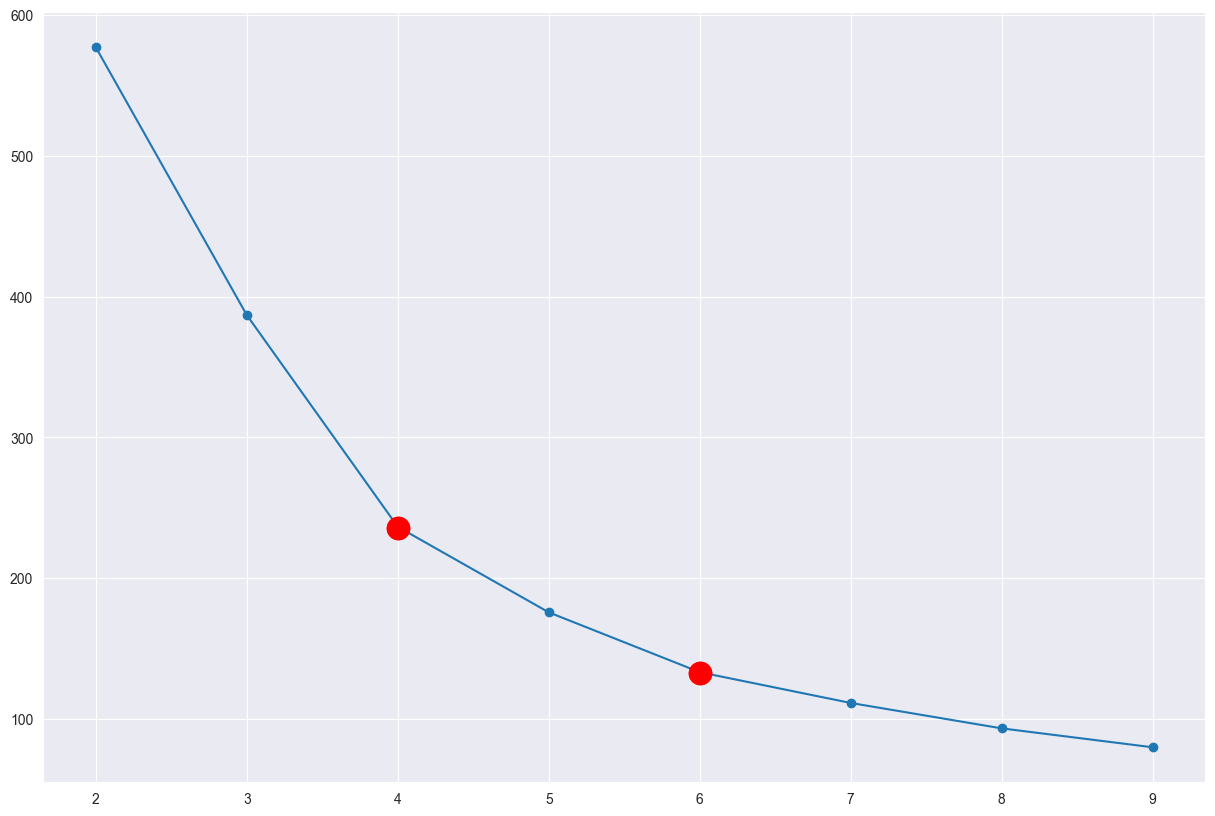

In [18]:
inertia = []
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, n_init=100, max_iter=1000)
    segmentacao_kmeans = kmeans.fit(segmentacao_reduzida)
    inertia.append(segmentacao_kmeans.inertia_)
plt.figure(figsize=(15, 10))
plt.plot(range(2, 10), inertia, '-o')
plt.plot([4, 4], [236, 236], 'o', c='red', markersize=16)
plt.plot([6, 6], [133, 133], 'o', c='red', markersize=16)
plt.show()

Pelo método do Ombro (Elbow Method), o número ideal de clusters é 6.

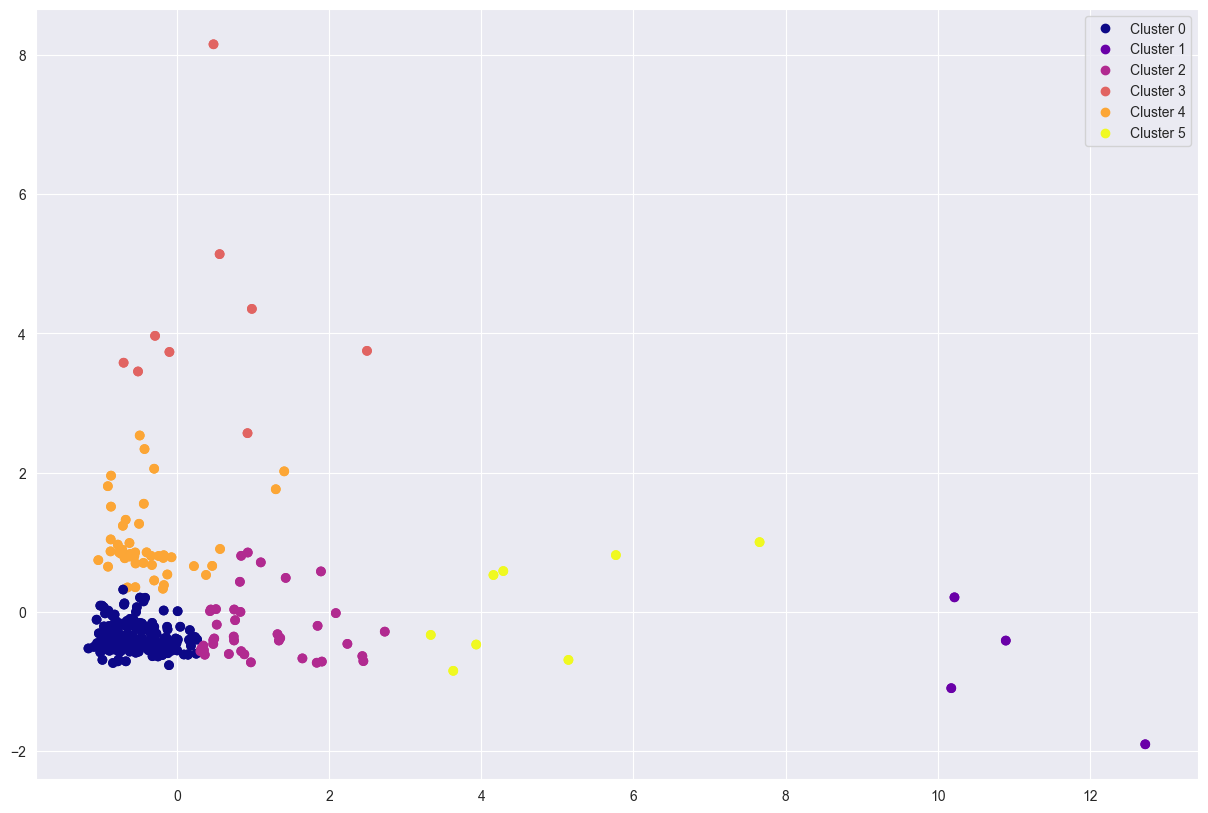

In [17]:
# Aplicando somente
kmeans = KMeans(n_clusters=6, n_init=10, max_iter=1000)
segmentacao_kmeans = kmeans.fit(segmentacao_reduzida)
segmentacao['cluster'] = segmentacao_kmeans.labels_
plt.figure(figsize=(15, 10))
plt.scatter(segmentacao_reduzida[:, 0], segmentacao_reduzida[:, 1], c=segmentacao_kmeans.labels_, cmap='plasma')
plt.legend(handles=plt.scatter(segmentacao_reduzida[:, 0], segmentacao_reduzida[:, 1], c=segmentacao_kmeans.labels_, cmap='plasma').legend_elements()[0], labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'])
plt.show()

### E se não fizéssemos a redução de dimensionalidade (PCA)?

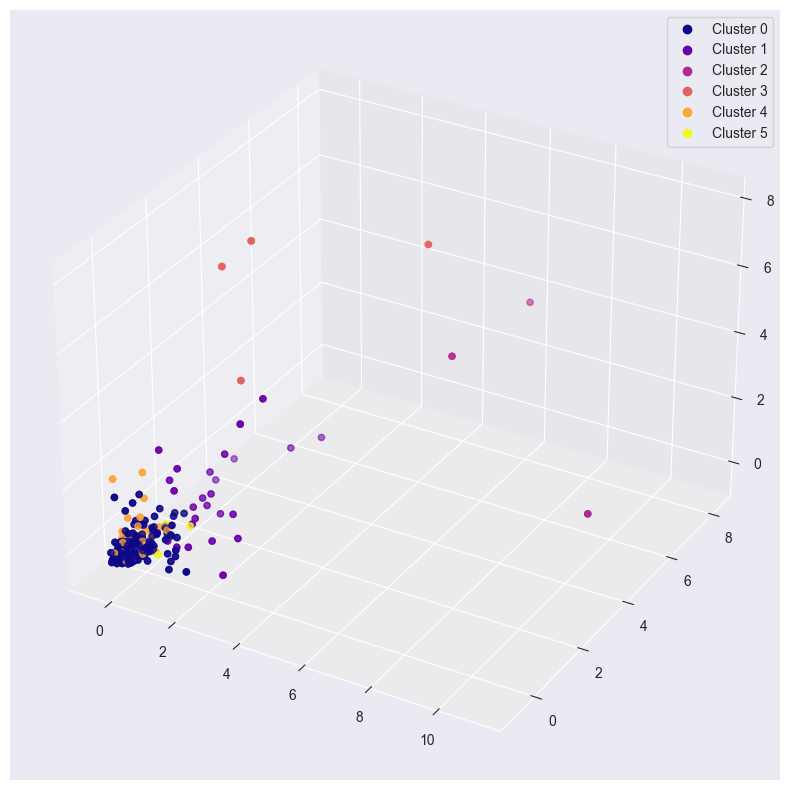

In [16]:
# Aplicando somente
kmeans = KMeans(n_clusters=6, n_init=10, max_iter=300)
segmentacao_kmeans = kmeans.fit(segmentacao_scaled)
segmentacao['cluster'] = segmentacao_kmeans.labels_
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(segmentacao_scaled[:, 0], segmentacao_scaled[:, 1], segmentacao_scaled[:, 2], c=segmentacao_kmeans.labels_, cmap='plasma')
ax.legend(handles=ax.scatter(segmentacao_scaled[:, 0], segmentacao_scaled[:, 1], segmentacao_scaled[:, 2], c=segmentacao_kmeans.labels_, cmap='plasma').legend_elements()[0], labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'])
plt.show()

### Análise dos clusters

In [ ]:
segmentacao.groupby('cluster').agg({'likes': ['count','mean'],
                           'comments': ['mean'],
                           'shares': ['mean'],
                           'views': ['mean',],
                           'duration': ['mean']}).round(2).sort_values(by=('likes', 'mean'), ascending=False).reset_index()

Quais são os usuários do cluster que tem maior média de likes?

In [ ]:
jetta[segmentacao['cluster'] == 2]['user'].value_counts()

### Modelagem de tópicos com as hashtags

Para trabalharmos com palavras, precisamos transformá-las em números. Um método é o Tf-Idf, que significa Term Frequency, Inverse Document Frequency. É uma conta que considera a frequência do termo *w* no documento *d* sobre o total de termos em *d*. O IDF é o inverso da frequência do termo *w* em todos os documentos. O TF-IDF é o produto desses dois termos. Ele vai falar sobre a importância de cada palavra em cada documento, resumidamente.

O NMF é um modelo não-supervisionado que vai decompor a matriz de termos em tópicos. Ele vai tentar encontrar os tópicos que melhor explicam os dados. NMF significa Non-Negative Matrix Factorization, ou Fatoração de Matriz Não-Negativa.

In [ ]:
stopwords = ['fy', 'viral', 'fyp', 'parati', 'foryou', 'foryoupage', 'fypシ', 'capcut', 'foryourpage']
jetta['challenges_clean'] = jetta['challenges'].str.split(', ').apply(lambda x: [word for word in x if word not in stopwords])

# Aplica o TFIDF e o NMF
tfidf = TfidfVectorizer(max_df=0.9, min_df=0.01, max_features=1000)
nmf = NMF(n_components=4)
challenges = tfidf.fit_transform(jetta['challenges_clean'].apply(lambda x: ' '.join(x)))
challenges_nmf = nmf.fit_transform(challenges)

for index, topic in enumerate(nmf.components_):
    print(f'Top 15 challenges por tópico: #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')